# Example 1: School Admissions

## Generate data

An admissions officer decides if to admit a student depending on his or her race, sex, and test score. 
Their choice $Y=1|X$ is characterized by the decision rule
$$Y = 1\{ \sigma(-2X_1 + X_2 + X_3/5 - 2.2) \geq .5 \}$$
where $X_1 \sim Bernoulli(.5)$ and $X_2 \sim Bernoulli(.3)$ and $X_3 \sim A + E$, where innate ability $A \sim N(6,1)$ and study effort $E \sim N(1,1)$, and $X_3$ is clamped to $[0, 10]$. 

Students self-report if they were admitted. However, they only respond to the survey if $Z=1|X,E$, where
$$Z = 1\{ \sigma(X_1 + 3X_2 + X_3/8 + E - 3.5) \geq .5 \}$$

We want to estimate the admissions officer's reliance on $X_1,X_2,X_3$. 
To do so, we must estimate $P(Y=1|X)$, but the missing data problem (with confounding due to $E$) only partially identifies this estimand.

In [1]:
import numpy as np

def gen_data(n):
  logistic = lambda x: 1 / (1 + np.exp(-x))

  X1 = np.random.binomial(1, .5, n)
  X2 = np.random.binomial(1, .3, n)
  A = np.random.normal(6, 1, n)
  E = np.random.normal(1, 1, n)
  X3 = (A + E).clip(0,10)
  Y = logistic(-2*X1 + X2 + X3/5 - 2.2) >= .5
  Z = logistic(X1 + 3*X2 + X3/8 + E - 1.5) >= .5
  X = np.vstack((X1,X2,X3)).T
  return (Y, X, Z)

fullN = 10000  # 10000 students applied
fullY, fullX, fullZ = gen_data(fullN)
Y, X, EZ = fullY[fullZ], fullX[fullZ], fullZ.mean()
print('Self-reported acceptance rate:', Y.mean().round(2))
print('Number of responses: %d / %d' % (len(Y), fullN))

Self-reported acceptance rate: 0.14
Number of responses: 8287 / 10000


## Bound $g(x) = E[Y|X]$

By the law of iterated expectation
$$E[Y|X] = E[ E[Y|X,Z] | Z] = E[Y|X,Z=1]P(Z=1) + E[Y|X,Z=0]P(Z=0)$$
We only observe $Y,X$ when $Z=1$ and we have $E[Z]$, so our identification result is
$$E[Y|X] \in [ E[Y|X,Z=1]P(Z=1) , \,\, E[Y|X,Z=1]P(Z=1) + P(Z=0) ]$$
Larger $P(Z=1)$ implies a smaller interval. The interval is just a point when $P(Z=1) = 1$.

Estimate $g_1(x) = E[Y|X,Z=1]$ by logistic regression of the observed $Y$ on $X$.

In [2]:
from sklearn.linear_model import LogisticRegression

g1 = LogisticRegression().fit(X, Y).predict
print('Logistic regression accuracy:', (g1(X) == Y).mean())

Logistic regression accuracy: 0.998069265114034


Define the lower and upper bounds for $g$, denoted $g_{min}$ and $g_{max}$.
<!-- If $E[Z] > .5$ then
$g_1(x) = 1$ implies $g_{min}(x) = 1$ and $g_{max}(x) = 1$;
$g_1(x) = 0$ implies $g_{min}(x) = 0$ and $g_{max}(x) = 0$;
so $g_{min} = g_{max} = g_1$.

If $E[Z] \leq .5$ then
$g_1(x) = 1$ implies $g_{min}(x) = 0$ and $g_{max}(x) = 1$;
$g_1(x) = 0$ implies $g_{min}(x) = 0$ and $g_{max}(x) = 1$;
so $g_{min} = 0$ and $g_{max} = 0$ regardless of $g_1$. -->

In [3]:
g_min = lambda x: g1(x) * EZ
g_max = lambda x: g1(x) * EZ + (1 - EZ)

## Examples

Bounds on admission for white men given test scores. 
This object is $E[Y|X_1=1, X_2=1, X_3]$.

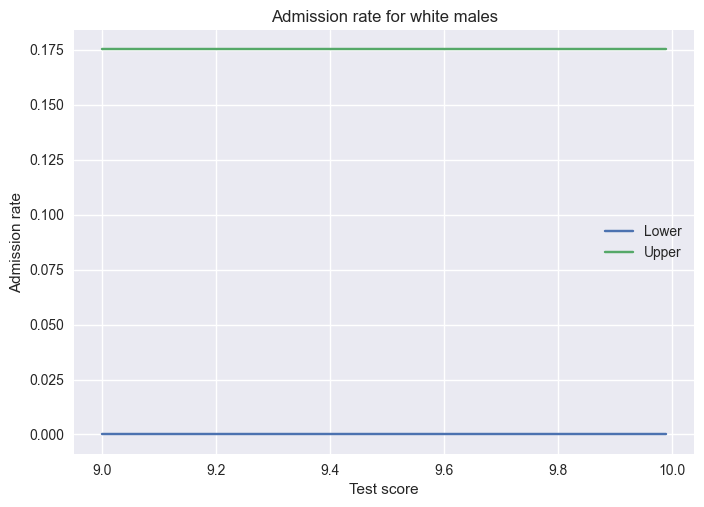

In [35]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')

def plot_ex_1():
  X3 = np.arange(9, 10, .01)
  n = len(X3)
  X = np.vstack((np.ones((2,n)), X3)).T
  Yl, Yu = g_min(X), g_max(X)

  fig = plt.figure()
  ax = fig.add_subplot()
  ax.plot(X3, Yl, label='Lower')
  ax.plot(X3, Yu, label='Upper')
  ax.set_title('Admission rate for white males')
  ax.set_xlabel('Test score')
  ax.set_ylabel('Admission rate')
  ax.legend()
plot_ex_1()

## Model reliance

Similar to (though not exactly as in) Fisher et al.,
$$\hat{e}_{orig} \equiv \frac{1}{n}\sum_{i=1}^n L(y_i, g(x_i))$$
where $g(x) = E[Y|X=x]$ is unknown.

We can derive the very conservative bounds $\hat{e}_{orig} \in [\hat{e}_{orig}^-, \hat{e}_{orig}^+]$ given by
$$\hat{e}_{orig}^- \equiv \frac{1}{n} \sum_{i=1}^n \min\{ L(y_i, g_{min}(x_i)), \,\, L(y_i, g_{max}(x_i)) \}$$
and $\hat{e}_{orig}^+$ by replacing $\min$ with $\max$.

In [4]:
loss = lambda Y, Ypred: (Y - Ypred) ** 2
e_orig_min = np.vstack( (loss(Y, g_min(X)), loss(Y, g_max(X)) )).min(axis=0).mean()
e_orig_max = np.vstack( (loss(Y, g_min(X)), loss(Y, g_max(X)) )).max(axis=0).mean()
print('e_orig in: [%.3f, %.3f]' % (e_orig_min, e_orig_max))

e_orig in: [0.002, 0.031]


Similar to (though not exactly as in) Fisher et al.,
$$\hat{e}_{switch} = \frac{1}{n(n-1)} \sum_{i=1}^n \sum_{j \ne i} L( y_j, g(w_{1[i]}, w_{2[j]}) )$$
where we are computing the model reliance on the subset $W_1$ of the covariates, and $W_2$ is the rest of the covariates. 
In this shuffling, we take each pair of rows $i \ne j$ and replace the covariates $w_{2[j]}$ with the values in $w_{1[i]}$. 
Thus, the marginal distribution of $W_1$ is the same, but $W_1$ is independent of $W_2$ and $Y$.
(Note: I slightly abuse notation for $g$ here.)

For a given partition, we derive the very conservative bounds $\hat{e}_{switch} \in [\hat{e}_{switch}^-, \hat{e}_{switch}^+]$ given by
$$\hat{e}_{switch}^- = \frac{1}{n(n-1)} \sum_{i=1}^n \sum_{j \ne i} \min\{ L( y_j, g_{min}(w_{1[i]}, w_{2[j]}) ), \,\, L( y_j, g_{max}(w_{1[i]}, w_{2[j]}) ) \}$$
and $\hat{e}_{switch}^+$ by replacing $\min$ with $\max$.

Compute the point-identified model reliance using Fisher's eq (3.4) because the sample is very large.

In the code below, I evaluate model reliance for the partitions
 1. $W_1 = (X_1), W_2 = (X_2, X_3)$
 2. $W_1 = (X_2), W_2 = (X_1, X_3)$
 3. $W_1 = (X_3), W_2 = (X_1, X_2)$

Does $\hat{e}_{switch}^-$ and $\hat{e}_{switch}^+$ need to be weighed to take into account that it is only a subset of the data?
For example, the *actual* lower bound is $\hat{e}_{switch}^- * E[Z]$ and upper bound is $\hat{e}_{switch}^- * E[Z] + (1 - E[Z])$?
Also, for intra-distribution comparisons, you don't need to subtract $\hat{e}_{orig}$.

In [37]:
import shuffle

def e_switch_range(col):
  """
  The min/max of e_switch when shuffling on [col].
  """
  arr_to_shuffle = np.hstack((X, Y.reshape(len(Y),1)))  # we have to keep track of Y along with X in the shuffle
  arr_shuffled = shuffle.switch(arr_to_shuffle, col)    # shuffled (X, Y)
  Xs = arr_shuffled[:,:-1]                              # all but last columns are X
  Ys = arr_shuffled[:,-1]                               # last column is Y
  g_min_Xs, g_max_Xs = g_min(Xs), g_max(Xs)
  losses = np.vstack( (loss(Ys, g_min_Xs), loss(Ys, g_max_Xs) ))
  e_switch_min = losses.min(axis=0).mean()
  e_switch_max = losses.max(axis=0).mean()
  # return (e_switch_min * EZ, e_switch_max * EZ + (1 - EZ))
  return (e_switch_min, e_switch_max)

mr_range = e_switch_range
# def mr_range(col):
#   e_switch_min, e_switch_max = e_switch_range(col)
#   return (e_switch_min - e_orig_max, e_switch_max - e_orig_min)

In [38]:
# use fullX and fullY, so there's no missing data problem and the counterfactual probabilities are point identified
g = lambda x: LogisticRegression().fit(fullX, fullY).predict(x) + 0
e_orig_pt = loss(fullY, g(fullX)).mean()

def e_switch_point(col):
  arr_to_shuffle = np.hstack((fullX, fullY.reshape(len(fullY),1)))  # we have to keep track of Y along with X in the shuffle
  arr_shuffled = shuffle.switch(arr_to_shuffle, col)                # shuffled X
  Xd = arr_shuffled[:,:-1]                                          # all but last columns are X
  Yd = arr_shuffled[:,-1]                                           # last column is Y
  e_switch = loss(Yd, g(Xd)).mean()
  return e_switch

mr_point = e_switch_point
# def mr_point(col):
#   return e_switch_point(col) - e_orig_pt

In [39]:
def e_switch_point_observed(col): # for Z = 1
  arr_to_shuffle = np.hstack((X, Y.reshape(len(Y),1)))  # we have to keep track of Y along with X in the shuffle
  arr_shuffled = shuffle.switch(arr_to_shuffle, col)    # shuffled X
  Xd = arr_shuffled[:,:-1]                              # all but last columns are X
  Yd = arr_shuffled[:,-1]                               # last column is Y
  e_switch = loss(Yd, g(Xd)).mean()
  return e_switch

mr_point = e_switch_point_observed

In [40]:
from matplotlib.pyplot import yticks

results = []  # [['baseline', mr_min, mr_max, mr_pt]]
for col in range(3):
  mr_min, mr_max = mr_range(col)
  mr_pt = mr_point(col)
  results.append(['X' + str(col + 1), mr_min, mr_max, mr_pt])
  print('MR on X%d: [%.3f, %.3f]' % (col + 1, mr_min, mr_max))
  print('  point value: %.3f' % mr_pt)

MR on X1: [0.095, 0.165]
  point value: 0.139
MR on X2: [0.120, 0.202]
  point value: 0.177
MR on X3: [0.039, 0.086]
  point value: 0.057


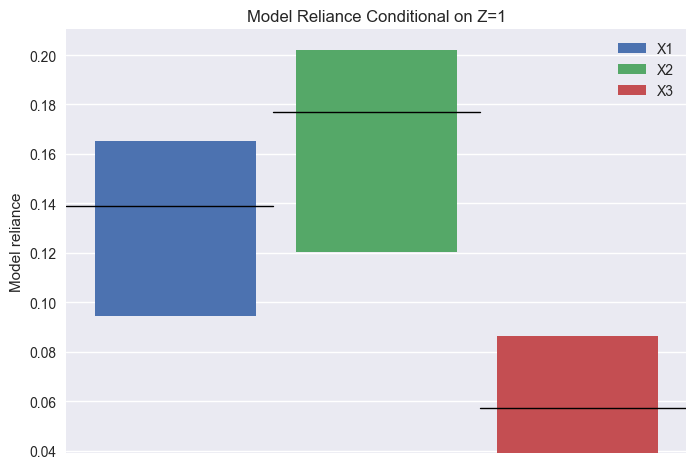

In [41]:
def plot_results_0():
  fig = plt.figure()
  ax = fig.add_subplot()
  ticks = []

  for col, (label, mr_min, mr_max, mr_pt) in enumerate(results):
    color = 'C' + str(col)
    ax.hlines(y=mr_pt, xmin=0, xmax=1, color=color, linestyle='--', label=label)
    ax.fill_between([0,1], mr_min, mr_max, alpha=.3)
    ticks += [mr_min, mr_pt, mr_max]
  
  yticks(ticks=ticks)
  ax.get_xaxis().set_visible(False)
  ax.set_ylabel('Model reliance')
  ax.legend()

def plot_results_1():
  fig = plt.figure()
  ax = fig.add_subplot()

  for col, (label, mr_min, mr_max, mr_pt) in enumerate(results):
    color = 'C' + str(col)
    ax.bar(col, mr_max - mr_min, bottom=mr_min, color=color, label=label)
    plt.axhline(xmin=col / 3, xmax=(col + 1) / 3, y=mr_pt, linewidth=1, color="black")
  
  ax.set_title('Model Reliance Conditional on Z=1')
  ax.get_xaxis().set_visible(False)
  ax.set_ylabel('Model reliance')
  ax.legend()

plot_results_1()